## Evaluate Models

How to evaluate time-series based models?

- how to evaluate : backtest/hindcast , evaluating on historical observations
- how to prepare train/test split so they retain temporal info :single split TimeSplit() from sklearn, multiple splits to evaluate multiple model,
  walk-forward validation(best approach)
- what measure/matrix to use performance: residual error(forcast error:actual -predicted), mean-forcast error, Squared mean error, Root squared mean error
  zero means zero errors thus good
- naive model/persistance model : model to give baseline performance to compare other models
- 

#### Persistence model

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [4]:
df = pd.read_csv('Pressure9',usecols=['Pressure9am'])

In [13]:
df1 = df.shift(1)
df1.columns = ['t']
df.columns = ['t+1']
X = pd.concat([df1,df],axis=1)
X.drop([0],inplace=True)

In [19]:
X.interpolate(method='linear',inplace=True)
X.isnull().sum()

t      0
t+1    0
dtype: int64

In [20]:
X

,t,t+1
1,1007.7,1010.6
2,1010.6,1007.6
3,1007.6,1017.6
4,1017.6,1010.8
5,1010.8,1009.2
...,...,...
3035,1030.6,1029.4
3036,1029.4,1029.4
3037,1029.4,1022.3
3038,1022.3,1018.8


In [27]:
train_size = int(len(X) * .66)
train,test = X[1:train_size],X[train_size:]

train_X,train_y = train.iloc[:,0],train.iloc[:,1]
test_X,test_y = test.iloc[:,0],test.iloc[:,1]

def model_persistence(x):
    return x

In [31]:
#implementing walk-forward evaluation
#train on data, then keep predicting for next time-step, find error,and keep
#repeating..for upcoming observation
predi = []
for x in test_X:
    yhat = model_persistence(x)
    predi.append(yhat)
rmse = np.math.sqrt(mean_squared_error(test_y,predi))
print("Test RMSE: %.3f" %rmse)

Test RMSE: 5.199


In [36]:
 predi[:3] 

[1026.2, 1028.2, 1030.4]

In [35]:
 test_y[:3]

2006    1028.2
2007    1030.4
2008    1029.6
Name: t+1, dtype: float64

### Visualizing Residual Error: does anything left to be modelled

Why to look at Residuals?

Residuals Errors  = actual - prediction

thus, they contains information as they are differences. If the prediction part has captured a little info of actual value, then residual error is more. This means that residual contains left-over part of the True value.

Visualizing the residual, to find left over pattern that can be modelled to improve the model. If the residual is random means that residual has't left any information. This is good.. for us. 

But, residual are generated, so this means may the model overforcast or underfocast.The less the Rmse,Mse the better...

**Ways to check the residual:**

- line plot
- stats summary like mean,std
- distribution of residual : hist,kde
- qqplot :compare to guassian distri
  
**Goal is to check if pattern left or random error**

**random error in residual is better**

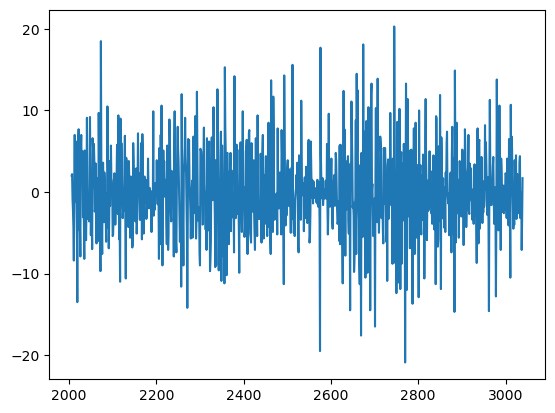

In [39]:
residual = test_y - predi
plt.plot(residual)

In [40]:
#stat summary of residals
residual.describe()

count    1034.000000
mean       -0.005513
std         5.201599
min       -20.900000
25%        -3.100000
50%        -0.300000
75%         3.075000
max        20.300000
Name: t+1, dtype: float64

(array([  2.,   2.,   9.,  19.,  37.,  94., 227., 249., 181., 116.,  53.,
         26.,  12.,   3.,   4.]),
 array([-20.9       , -18.15333333, -15.40666667, -12.66      ,
         -9.91333333,  -7.16666667,  -4.42      ,  -1.67333333,
          1.07333333,   3.82      ,   6.56666667,   9.31333333,
         12.06      ,  14.80666667,  17.55333333,  20.3       ]),
 <BarContainer object of 15 artists>)

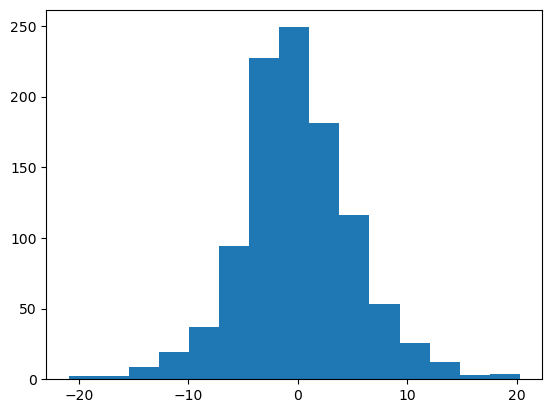

In [42]:
# distribution of residual
plt.hist(residual,bins=15)

<Axes: ylabel='Density'>

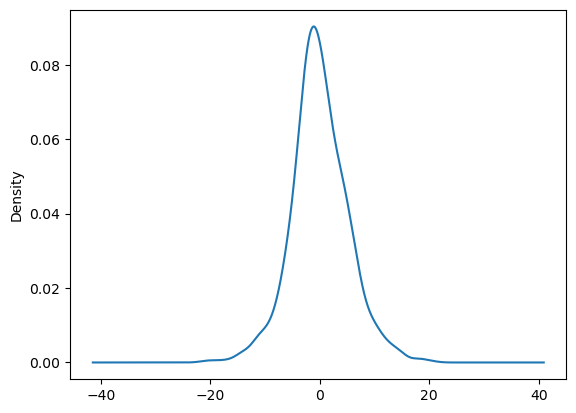

In [45]:
residual.plot(kind='kde') #gaussina distribution with mean close to 0,

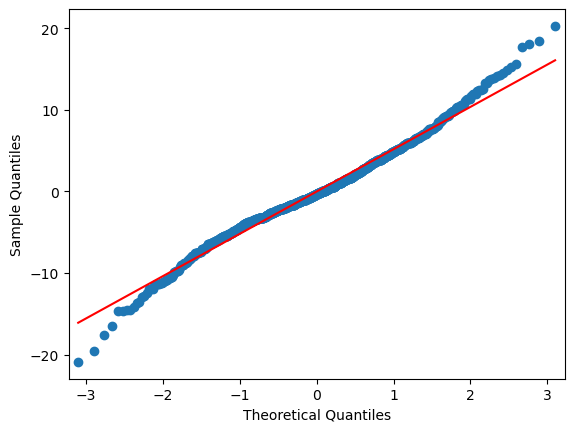

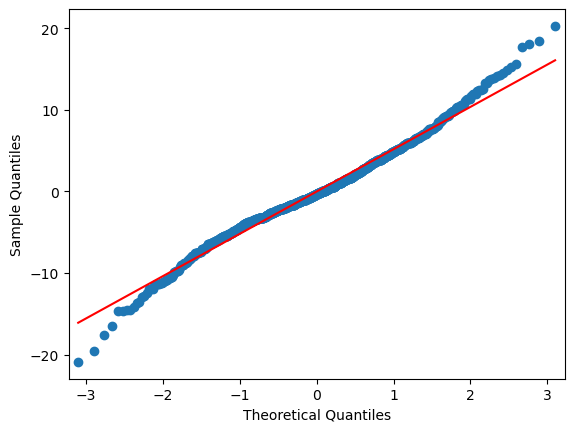

In [49]:
# checking the gaussian distribution in the residual
# qq:quantile plot - compares the ideal gaussian distribution with the given distribution,
#line represents the actuall gaussian distribution,scatters shows the given distibution
#if line&scatter aligns perfectly then gaussian disti..
from statsmodels.graphics.gofplots import qqplot
qqplot(residual,line='r')

#here,in our residual, the tails seems not follow the gaussi distribution..as they move away from line

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

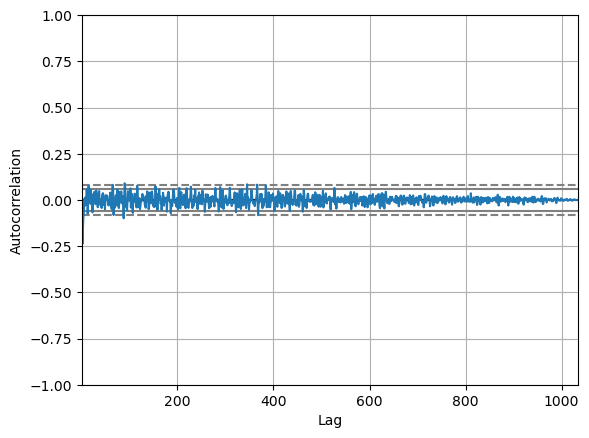

In [50]:
#checking autocorrelation if any temporal data left in residual
pd.plotting.autocorrelation_plot(residual)
#seems no left temporal info in residual

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

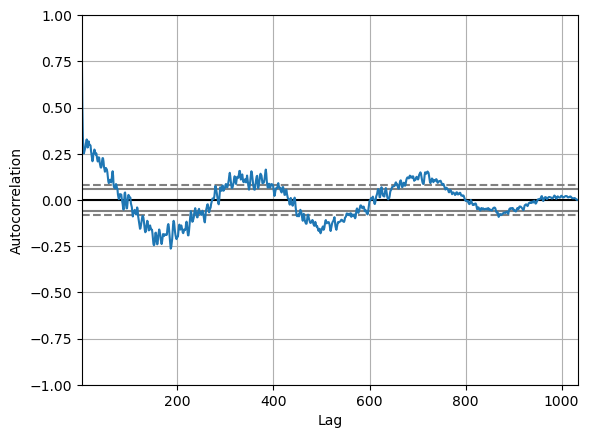

In [53]:
pd.plotting.autocorrelation_plot(test_X) #temporal data in lag-200